# Plot analytics

In [47]:
import contextlib
import json
import math
import os

import matplotlib.pyplot as plt
import scipy
from cycler import cycler

## Utils

In [48]:
LOGS_PATH = "../logs/"

LOGS_DIR: dict[str, str] = {
    "a2c": "a2c",
    "reinforce": "reinforce",
    "dqn": "dqn",
    "cnn1d": "cnn_1d",
    "cnn2d": "cnn_2d",
    "lstm": "lstm",
    "bilstm": "lstm_bi",
    "lstm_attn": "lstm_attn",
    "bilstm_attn": "lstm_bi_attn",
}

BASELINES = [
    "cnn1d",
    "cnn2d",
    "lstm",
    "bilstm",
    "lstm_attn",
    "bilstm_attn",
]

In [49]:
def load_json(path: str) -> dict:
    with open(path, "r") as f:
        return json.load(f)


def get_max_index(path: str) -> int:
    max_index = 0
    for file in os.listdir(path):
        with contextlib.suppress(ValueError):
            max_index = max(max_index, int(os.path.splitext(file)[0]))
    return max_index

In [50]:
def moving_average(x, w=10):
    w = min(w, max(1, len(x) // 10))
    return scipy.signal.savgol_filter(x, w, min(3, w - 1))

In [51]:
PREDEFINED_COLORS = [
    "#ffa500",
    "#c83cbc",
    "#1c1c84",
    "#ff0000",
    "#08a4a7",
    "#008000",
]


def draw_plots(
    data_dict: dict,
    plots: list[tuple[dict, dict]],
    title: str = "",
    ylim=None,
    row_plots: int = 1,
    plot_width: float = 8,
    plot_height: float = 4,
    use_rainbow: bool = False,
    use_common_legend: bool = True,
    adjust: bool = False,
):
    num_plots = len(plots)
    num_entities = len(data_dict)
    if use_rainbow:
        num_colors = num_entities
        cm = plt.get_cmap("gist_rainbow")
        colors = [cm(1.0 * i / num_colors) for i in range(num_colors)]
    else:
        colors = PREDEFINED_COLORS

    style_cycler = cycler(linestyle=["-", "--", ":", "-."]) * cycler(color=colors)
    column_plots = math.ceil(num_plots / row_plots)

    fig, axs = plt.subplots(
        column_plots,
        row_plots,
        figsize=(plot_width * row_plots, plot_height * column_plots),
    )

    if len(title) > 0:
        fig.suptitle(title, fontsize=14, y=1)
    axs_list = [axs] if column_plots * row_plots == 1 else list(axs.flat)

    for ax in axs_list:
        ax.grid()
        ax.set_prop_cycle(style_cycler)
        if ylim is not None:
            ax.set_ylim(top=ylim)
        ax.set_visible(False)

    for ax, (p1, p2) in zip(axs_list, plots):
        ax.set_visible(True)

        ax.set_title(f"{p2['axis_name']} over {p1['axis_name']}")
        ax.set(xlabel=p1["axis_label"], ylabel=p2["axis_label"])

        if p1.get("log", False):
            ax.set_xscale("log")
        if p2.get("log", False):
            ax.set_yscale("log")

        longest_x_values = []
        for entity_name, entity_dict in data_dict.items():
            x_values = entity_dict[p1.get("ref", None) or p1["axis_name"]]
            if len(x_values) > len(longest_x_values):
                longest_x_values = x_values
            y_values = entity_dict[p2.get("ref", None) or p2["axis_name"]]

            average_w = p2.get("averaged", None)
            if average_w:
                y_values = moving_average(y_values, average_w)
            ax.plot(x_values, y_values, label=entity_name)
            ax.scatter(x_values[-1], y_values[-1], s=15)

        p2vs = p2.get("values", [])
        for p2v in p2vs:
            y_values = data_dict[p2v.get("ref", None) or p2v["name"]]
            try:
                iter(y_values)
                ax.plot(x_values, y_values, label=p2v["name"])
                ax.scatter(x_values[-1], y_values[-1], s=15)
            except TypeError:
                ax.plot(x_values, [y_values] * len(x_values), label=p2v["name"])

    if use_common_legend:
        lines_labels = [axs_list[0].get_legend_handles_labels()]
        lines, labels = [sum(x, []) for x in zip(*lines_labels)]
        fig.legend(
            lines,
            labels,
            scatterpoints=1,
            markerscale=3,
            loc="outside lower center",
            ncol=min(6, num_entities),
            bbox_to_anchor=(0.5, -0.05),
        )
    else:
        if num_entities > 1:
            for ax, _ in zip(axs_list, plots):
                ax.legend()

    plt.tight_layout()
    if adjust:
        plt.subplots_adjust(
            top=1 - 0.1 / (num_plots**0.5), bottom=0.12 / (num_plots**2), hspace=0.15
        )

    plt.show()
    return fig

## Baseline utils

In [52]:
def choose_best_baseline_experiment(baseline_name: str) -> str:
    baseline_log_path = os.path.join(LOGS_PATH, LOGS_DIR[baseline_name])

    best_experiment = ""
    best_loss = 2

    for experiment_dir in os.listdir(baseline_log_path):
        with contextlib.suppress(Exception):
            best_dict = load_json(
                os.path.join(baseline_log_path, experiment_dir, "best.json")
            )
            experiment_loss = next(iter(best_dict.values()))
            if experiment_loss < best_loss:
                best_experiment = experiment_dir
                best_loss = experiment_loss

    return f"{baseline_log_path}/{best_experiment}"


def get_baseline_experiment(experiment_path: str) -> tuple[dict, tuple[int, float]]:
    last_idx = get_max_index(experiment_path)

    data_dict = load_json(
        os.path.join(experiment_path, str(last_idx), "data/log_data.json")
    )
    best_dict = load_json(os.path.join(experiment_path, "best.json"))

    epoch, loss = next(iter(best_dict.items()))

    return data_dict, (int(epoch), loss)

In [58]:
def draw_baseline_plots(data_dict: dict, **kwargs):
    plot_epoch_axis = {"axis_name": "Epoch", "axis_label": "Epoch"}
    plot_time_axis = {"axis_name": "Time", "axis_label": "Running time, seconds"}
    log_plots = [
        (
            plot_epoch_axis,
            {"axis_name": "Mean Loss", "axis_label": "Loss", "averaged": 100},
        ),
        (
            plot_time_axis,
            {"axis_name": "Mean Loss", "axis_label": "Loss", "averaged": 100},
        ),
        (
            {**plot_epoch_axis, "ref": "Eval Epoch"},
            {"axis_name": "Mean Test Loss", "axis_label": "Loss"},
        ),
        (
            {**plot_time_axis, "ref": "Eval Time"},
            {"axis_name": "Mean Test Loss", "axis_label": "Loss"},
        ),
    ]

    draw_plots(data_dict, log_plots, row_plots=2, **kwargs)

## Baselines

In [59]:
baseline_logs = {}

print(f"{'BASELINE':<12} | {'EPOCH':<10} | {'LOSS':<10}")
for baseline in BASELINES:
    logs, (best_epoch, best_loss) = get_baseline_experiment(
        choose_best_baseline_experiment(baseline)
    )
    baseline_logs[baseline] = logs
    print(f"{baseline:<12} | {best_epoch:<10} | {best_loss:<10}")

BASELINE     | EPOCH      | LOSS      
cnn1d        | 680        | 0.1443049750290811
cnn2d        | 1110       | 0.13314360574198267
lstm         | 5320       | 0.1604354648035951
bilstm       | 80         | 0.1601444248110056
lstm_attn    | 10         | 0.16581105250710002
bilstm_attn  | 70         | 0.167869355166719


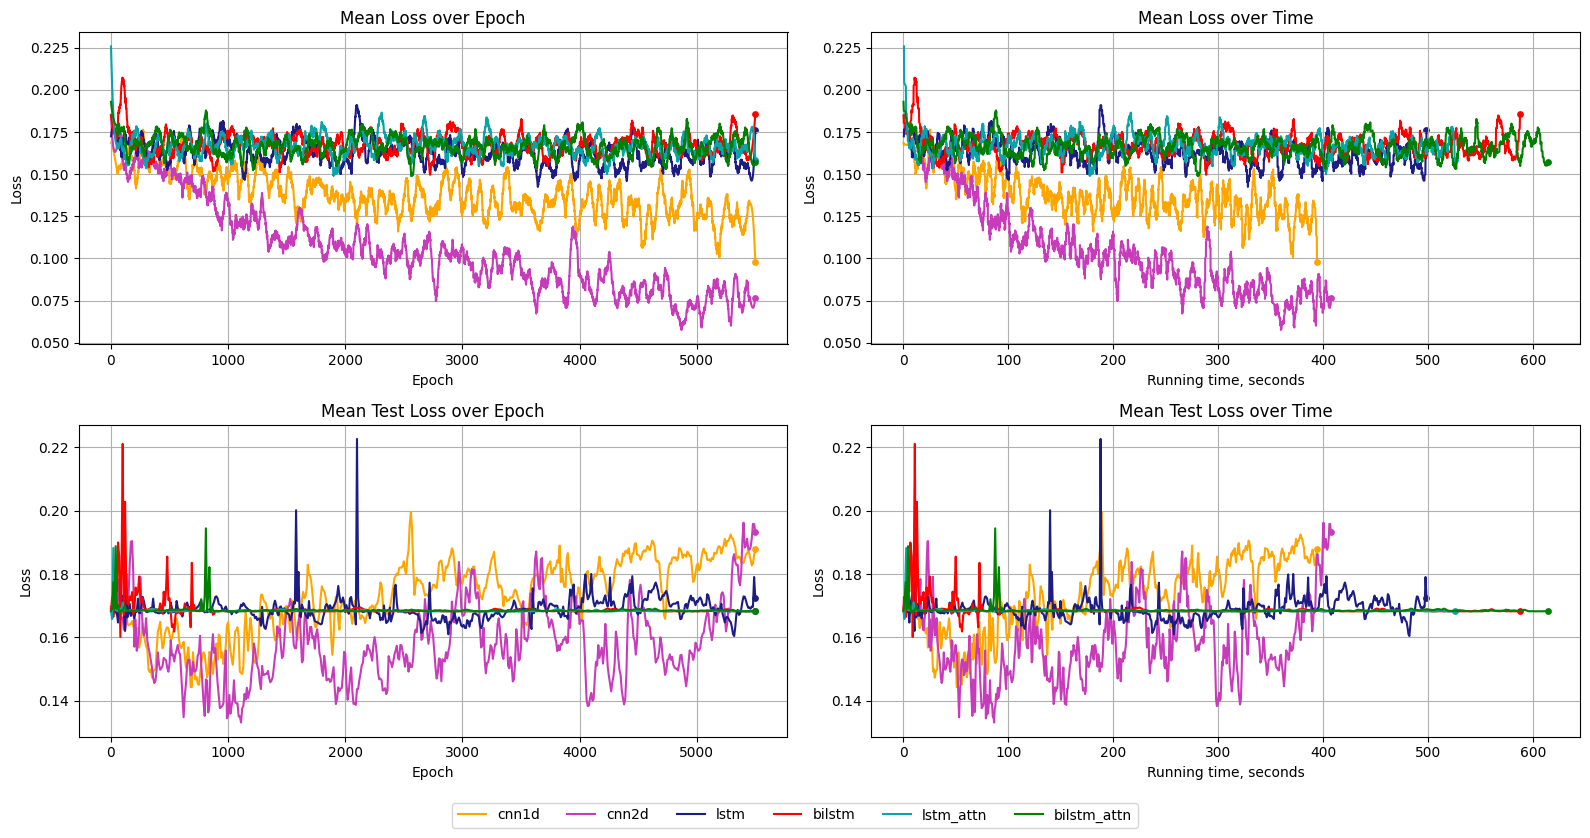

In [60]:
draw_baseline_plots(baseline_logs)